#  2-Causality



---
**Outline**

1. Review
2. Session 1: How to Not Measure Causality
   - Simpson Paradox: Berkeley Gender Bias Case
   - Variable Ommitted Bias Case: Wage on Employment
   - Simulating P-hacking
3. Session 2: Describing Relationship
   - Woman Labor

---
## Correlation vs. Causation

- It's important to avoid mistaking correlation for causation.
- Identified a correlation between two variables doesn't tells you the causes one falls into a particular category or value.
---
## Interpreting Linear Regression Coefficient

- Do not interpret coefficient in the causal ways, unless the study are in
  - Randomized controlled experiment. e.g A/B Testing
  - Other validly measured causal inference method.
- Why? There are likely unobserved variables that can either increase or decrease the coefficient.
---
## p-value
- p-value is used to show how likely the difference we observed or lager could occur by chance alone.
- The p-value convey no information about the size of an effect, which is represented by the effect estimate and confidence interval.
- The misunderstood p-value yield to ambition obtaining statistically significant p-value
- Example of p-hacking:
  - Researchers would do repeated experiments until the result is statistically significant
  - When in an experiment the p-value is 0.059, “so close” results. Researcher adds more samples (n) to the so close trials and then tests the hypothesis again

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt

# Simpson Paradox: Berkeley Gender Bias Case
---

- In 1973, Berkeley, a highly esteemed university in the United States, received a large number of applications for its graduate school.
- However, the question remains: Does gender affect the admission?

### Load Data

In [4]:
admission = pd.read_csv("berkeley.csv")
print(admission.shape)

admission.head()

(12763, 4)


,Year,Major,Gender,Admission
0,1973,C,F,Rejected
1,1973,B,M,Accepted
2,1973,Other,F,Accepted
3,1973,Other,M,Accepted
4,1973,Other,M,Rejected


### Variables Description

- Year: The application year (this data is always 1973)
- Major: An anonymized major code (either A, B, C, D, E, F, or Other). The specific majors are unknown except that A-F are the six majors with the most applicants in Fall 1973
- Gender: Applicant self-reported gender (either M or F)
- Admission: Admission decision (either Rejected or Accepted)

### Analysis

In [5]:
admission = admission.drop(admission[admission["Major"]=="Other"].index).reset_index()
admission

,index,Year,Major,Gender,Admission
0,0,1973,C,F,Rejected
1,1,1973,B,M,Accepted
2,6,1973,F,F,Accepted
3,9,1973,A,M,Accepted
4,11,1973,B,M,Accepted
...,...,...,...,...,...
4834,12747,1973,A,M,Accepted
4835,12748,1973,F,M,Rejected
4836,12752,1973,A,M,Accepted
4837,12754,1973,A,M,Accepted


In [6]:
# Create table of total admission in each gender
tab = pd.crosstab(admission['Admission'], admission['Gender'])

# Calculate the proportion of admission in each gender
prop_adm_by_gender = tab/tab.sum(axis = 0)
prop_adm_by_gender

Gender,F,M
Admission,,
Accepted,0.303542,0.502996
Rejected,0.696458,0.497004


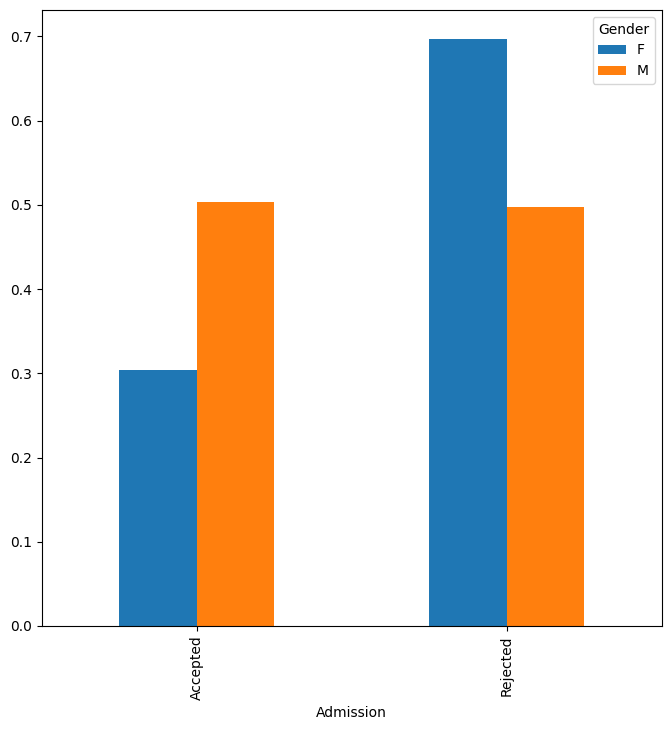

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
prop_adm_by_gender.plot(kind='bar', ax=ax)
plt.show()

- Based on the table, it is evident that the acceptance rate at Berkeley differed for male and female applicants, with 44.5% of male applicants being accepted compared to 30.4% of female applicants.
- It shows gender being male correlates to higher acceptance rate

This raises a concerning question: "Was there potential discrimination against women by Berkeley's graduate admissions major during that year?"
- Nevertheless, it is essential to keep in mind that the analysis conducted was based on an observational study, could have other variables that explain the acceptance rate between gender.
- In this particular case, the major chosen by each applicant was provided, and it is possible that the choice of major could explain the difference of each gender acceptance. Let's try to calculate admission based on the major chosen by the applicants.

In [8]:
# Calculate total admission based on major and gender
ucb_by_dept = admission.groupby(['Major','Gender','Admission']).size()
ucb_by_dept

Major  Gender  Admission
A      F       Accepted      89
               Rejected      19
       M       Accepted     825
               Rejected     313
B      F       Accepted      17
               Rejected       8
       M       Accepted     353
               Rejected     207
C      F       Accepted     201
               Rejected     392
       M       Accepted     120
               Rejected     205
D      F       Accepted     131
               Rejected     244
       M       Accepted     138
               Rejected     279
E      F       Accepted      94
               Rejected     299
       M       Accepted      53
               Rejected     138
F      F       Accepted      25
               Rejected     316
       M       Accepted      22
               Rejected     351
dtype: int64

In [9]:
# Calculate percentage admission based on major and gender
ucb_by_dept_prop = (ucb_by_dept/ucb_by_dept.groupby(['Major','Gender']).sum())*100
ucb_by_dept_prop

Major  Gender  Admission
A      F       Accepted     82.407407
               Rejected     17.592593
       M       Accepted     72.495606
               Rejected     27.504394
B      F       Accepted     68.000000
               Rejected     32.000000
       M       Accepted     63.035714
               Rejected     36.964286
C      F       Accepted     33.895447
               Rejected     66.104553
       M       Accepted     36.923077
               Rejected     63.076923
D      F       Accepted     34.933333
               Rejected     65.066667
       M       Accepted     33.093525
               Rejected     66.906475
E      F       Accepted     23.918575
               Rejected     76.081425
       M       Accepted     27.748691
               Rejected     72.251309
F      F       Accepted      7.331378
               Rejected     92.668622
       M       Accepted      5.898123
               Rejected     94.101877
dtype: float64

In [10]:
ucb_by_dept_prop = pd.DataFrame(ucb_by_dept_prop.unstack()["Accepted"])
ucb_by_dept_prop

Accepted
Major Gender           
A     F       82.407407
      M       72.495606
B     F       68.000000
      M       63.035714
C     F       33.895447
      M       36.923077
D     F       34.933333
      M       33.093525
E     F       23.918575
      M       27.748691
F     F        7.331378
      M        5.898123

In [11]:
ucb_by_dept_prop["Applicant"] = admission.groupby(['Major','Gender']).size()
ucb_by_dept_prop.stack().unstack(level=1).unstack()

Gender          F                    M          
         Accepted Applicant   Accepted Applicant
Major                                           
A       82.407407     108.0  72.495606    1138.0
B       68.000000      25.0  63.035714     560.0
C       33.895447     593.0  36.923077     325.0
D       34.933333     375.0  33.093525     417.0
E       23.918575     393.0  27.748691     191.0
F        7.331378     341.0   5.898123     373.0

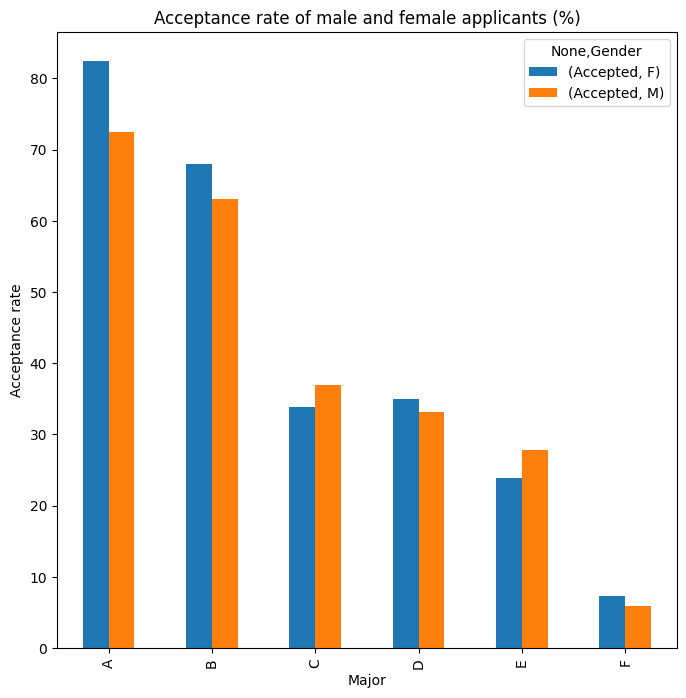

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
ucb_by_dept_prop[["Accepted"]].unstack().plot(kind='bar', ax=ax)

plt.title("Acceptance rate of male and female applicants (%)")
plt.ylabel("Acceptance rate")
plt.show()

- Now that we do analysis by major, although men were indeed more likely to be admitted into Major C and E, women were more likely to be admitted into all other majors

What Happened?

- Major A and Major B were considered relatively easier to get into, as they had acceptance rates exceeding 50%.
- However if we look at the number of each male or female applicant in each major, we see this figure

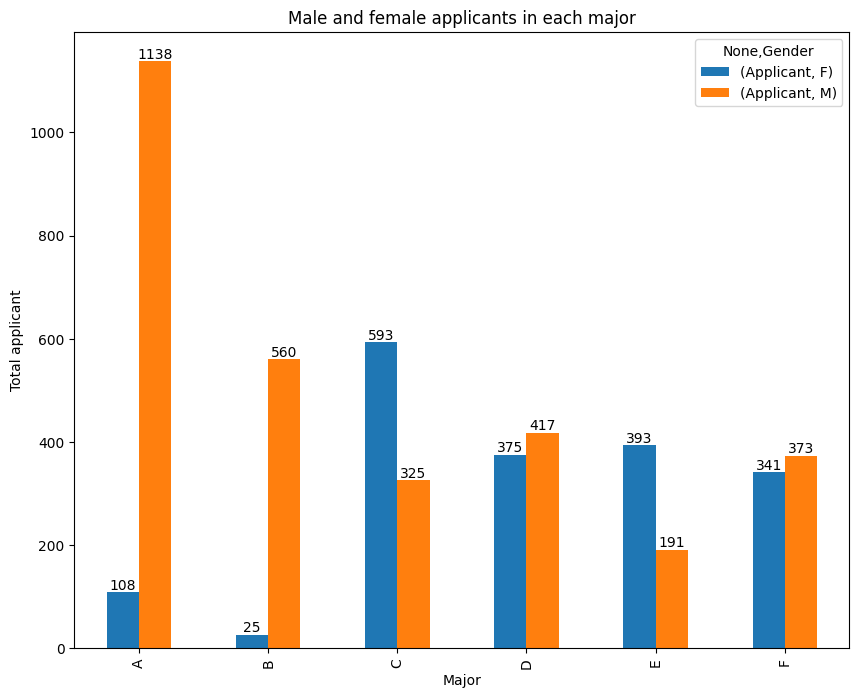

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
ucb_by_dept_prop[["Applicant"]].unstack().plot(kind='bar', ax=ax)

for c in ax.containers:
    # set the bar label
    ax.bar_label(c, fmt='%.0f', label_type='edge')

plt.title("Male and female applicants in each major")
plt.ylabel("Total applicant")
plt.show()

- Major A and Major B were considered relatively easier to get into, as they had acceptance rates exceeding 50%.
- However if we look at the number of each male or female applicant in each major, we see this figure

### Simpson Paradox
- Berkeley wasn’t biased, instead, Simpson’s Paradox was occurring!
- Why paradox? we tend to see that men are more likely to be accepted is causal. Since it is causal, it was men are more likely to be accepted in all majors. However it contradict the data from each major we see.
- It can seem surprising that one gender looks better overall, but
the other looks better when we restrict the comparison.

Simpson's Paradox refers to a phenomenon in which a trend appears in different groups of data but disappears or reverses when these groups are combined.

- In other words, the overall percentages in two groups (male and female) can be misleading because of other variable, in this case the major they choose
- When we control for major, the acceptance rate difference of gender disappears. In fact, it even reverses.

### Conclusion

- The unobserved variable, in this case, the choice of major presented an opposite admission difference than what was initially perceived.
- Comparing women who applied to Major A with men who applied to Major A, and likewise for other majors, provided better comparison
- This classic example emphasizes that in observational studies, relying solely on overall percentages to draw causation statement can be misleading and that a deeper analysis is necessary to draw reliable conclusions.

## Variable Ommitted Bias: College Degree on Earning
---

### Background
- Machine Learning models are great in assessing statistical relationships.
- However, without making substantial assumptions about the data, these models are unable to establish causal effects.
- To demonstrate this limitation, let's simulate a scenario where we aim to address a fundamental question in the field of economics: What is the causal impact of obtaining a college degree on hourly wages?

### Objective
Estimate the cause-and-effect relationship between obtaining a college degree and earning an hourly wage

### Data Generating Process

- Here, we generate the data we will use
- The data generating process is laid out in the code below.

In [14]:
# We will generate 10000 samples
n_samples = 10_000

# For reproducible results
rand = np.random.RandomState(32)

# Draw work experience in years and a measure of ability from Normal distributions
experiences = rand.normal(20, 10, size=n_samples).astype(int)
experiences[experiences < 0] = 0
abilities = rand.normal(0, 0.15, size=n_samples)

# While the hourly wage of one of the parents is drawn from a transform Beta distribution.
# Beta distribution draws continuous number from 0 and 1,
# a and b parameters are selected to create skew data because wage data typically have a positive skew.
parent_hourly_wages = 50 * rand.beta(a = 2, b = 8, size=n_samples)
parent_hourly_wages[parent_hourly_wages < 0] = 0

In [15]:
# Then create an indicator for college degree, which is positively influenced by ability and parental hourly wage.
college_degrees = (9 * abilities + 0.02 * parent_hourly_wages + rand.randn(n_samples) > 0.7).astype(int)

True Coefficients
- We model hourly wages as a linear function of all mentioned variables and a random component.

$$\text{HourlyWage} = 0.2\text{Experience} + \text{ParentHourlyWage} + 2\text{CollegeDegree} + 5\text{Ability} + \epsilon$$

- We call this model as our true generative model as the anchor of truth regarding the unbiased coefficients

In [16]:
true_coef = {"experience": 0.2,
             "parent_hourly_wage": 1.0,
             "college_degree": 2.0,
             "ability": 5.0,}

In [17]:
hourly_wages = (true_coef["experience"] * experiences
                + true_coef["parent_hourly_wage"] * parent_hourly_wages
                + true_coef["college_degree"] * college_degrees
                + true_coef["ability"] * abilities
                + rand.normal(0, 1, size=n_samples))

hourly_wages[hourly_wages < 0] = 0

In [18]:
wage = pd.DataFrame({"college_degree": college_degrees, "ability": abilities,
                   "hourly_wage": hourly_wages, "experience": experiences,
                   "parent_hourly_wage": parent_hourly_wages,})

### Visualization of Simulated Data

The distribution of each variable is illustrated in the plot below, along with pairwise scatterplots.

Text(0.5, 0, 'college degree')

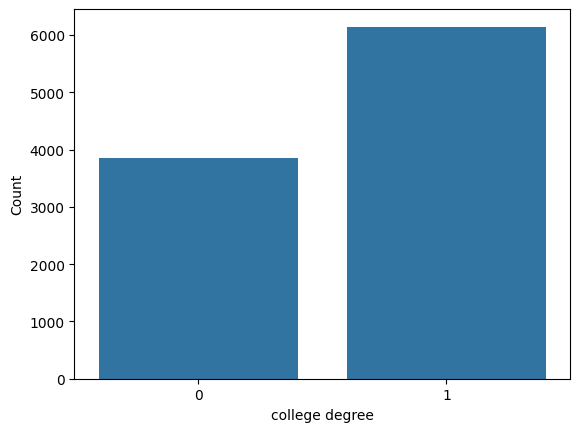

In [19]:
sns.barplot(x = wage["college_degree"].unique(),
            y= wage["college_degree"].value_counts().to_numpy(),)

plt.ylabel("Count")
plt.xlabel("college degree")

<Axes: xlabel='college_degree', ylabel='ability'>

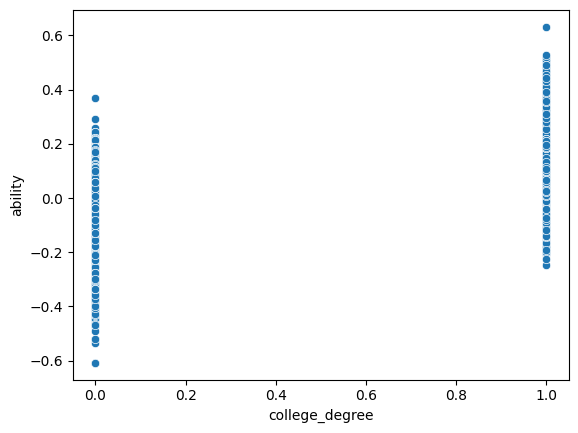

In [20]:
sns.scatterplot(x = wage["college_degree"], y = wage["ability"])

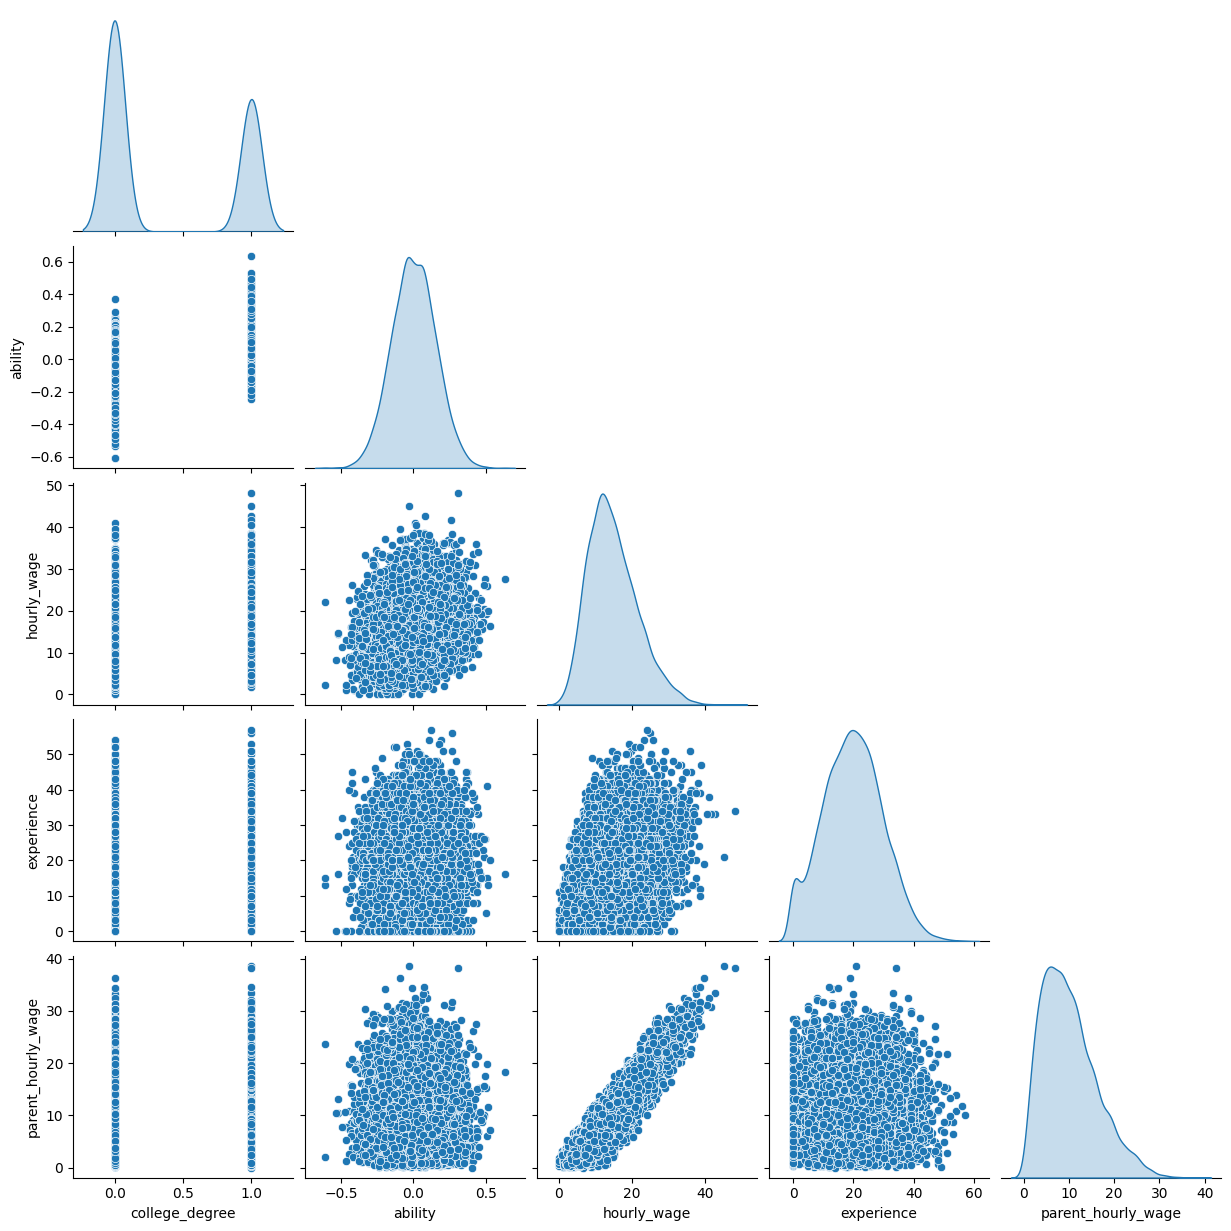

In [21]:
grid = sns.pairplot(wage, diag_kind="kde", corner=True)

### Regression Analysis

- First, train a predictive model, a Linear Regression model.
- In this model, we assume that all variables used by the true generative model are available.

In [22]:
# Create OLS model object
model = sm.ols('hourly_wage ~ experience + parent_hourly_wage + college_degree + ability', wage)

# Fit the model
results = model.fit()

# Print the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            hourly_wage   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 1.080e+05
Date:                Fri, 18 Jul 2025   Prob (F-statistic):               0.00
Time:                        22:17:21   Log-Likelihood:                -14231.
No. Observations:               10000   AIC:                         2.847e+04
Df Residuals:                    9995   BIC:                         2.851e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0670      0

In [23]:
features_names = ["experience","parent_hourly_wage","college_degree","ability"]

model_coef = pd.Series(results.params, index = features_names)
coef = pd.concat([pd.Series(true_coef), model_coef],
                 keys=["Coefficients of true generative model", "Model coefficients"],
                 axis=1,)

coef

,Coefficients of true generative model,Model coefficients
experience,0.2,0.201207
parent_hourly_wage,1.0,1.003094
college_degree,2.0,2.019897
ability,5.0,4.955175


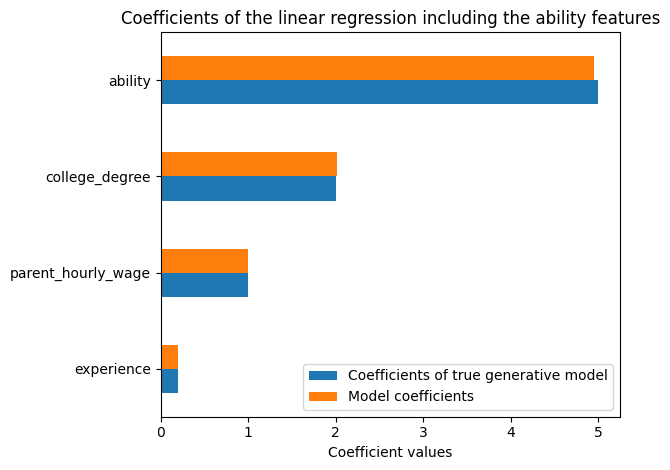

In [24]:
ax = coef.plot.barh()
ax.set_xlabel("Coefficient values")
ax.set_title("Coefficients of the linear regression including the ability features")
_ = plt.tight_layout()

#### Exclude Ability Variable
- In reality, it is often difficult to directly observe intellectual abilities, or they may only be inferred through proxies that also indirectly measure education (such as IQ tests).

In [25]:
# Create OLS model object
model = sm.ols('hourly_wage ~ experience + parent_hourly_wage + college_degree', wage)

# Fit the model
results_without_ability = model.fit()

# Print the results
print(results_without_ability.summary())

                            OLS Regression Results                            
Dep. Variable:            hourly_wage   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 1.072e+05
Date:                Fri, 18 Jul 2025   Prob (F-statistic):               0.00
Time:                        22:17:28   Log-Likelihood:                -15668.
No. Observations:               10000   AIC:                         3.134e+04
Df Residuals:                    9996   BIC:                         3.137e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4110      0

In [26]:
features_names = ["experience","parent_hourly_wage","college_degree"]
model_coef = pd.Series(results_without_ability.params, index = features_names)

coef = pd.concat([pd.Series(true_coef)[features_names], model_coef],
                 keys=["Coefficients of true generative model", "Model coefficients"],
                 axis=1,)
coef

,Coefficients of true generative model,Model coefficients
experience,0.2,0.201714
parent_hourly_wage,1.0,0.999727
college_degree,2.0,3.008256


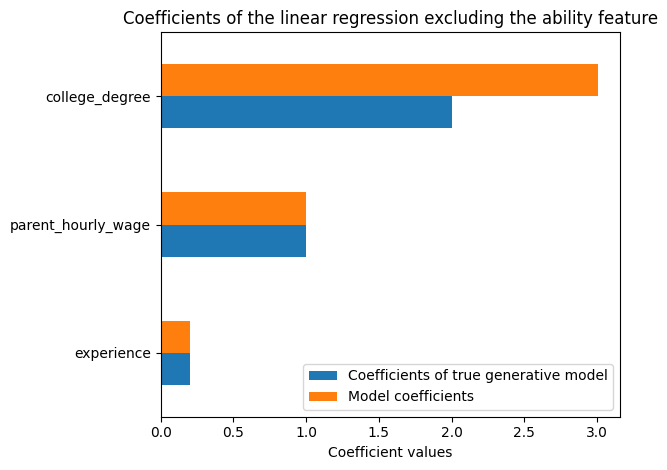

In [27]:
ax = coef.plot.barh()
ax.set_xlabel("Coefficient values")
_ = ax.set_title("Coefficients of the linear regression excluding the ability feature")
plt.tight_layout()
plt.show()

### Conclusion

- What is the cause-and-effect relationship between obtaining a college degree and earning an hourly wage? We can't answer causal question, since under the condition we have unobserved variable, we will mistakenly answer the question with bias. It's called omitted variable bias.
- To estimate causal effects in the presence of confounding, Researchers often perform experiments in which the treatment variable (such as obtaining a college degree) is randomly assigned. When conducting an experiment is not feasible due to cost or ethical reasons, Researchers may use other causal inference method.

## Simulating P-Hacking - $n$ chasing</font>
---


- $n$ chasing, or **adding** new observations to an already-analyzed experiment can increase your experiment's false positive rate.
- $n$ chasing is a **common form** of p-hacking.
- **Do not** do it.
- We will simulate the $n$ chasing.

[Reference](https://dustinstansbury.github.io/theclevermachine/p-hacking-n-chasing)

### **Simple $n$ chasing simulation**
---

- A well-behaved statistical test should provide uniformly-distributed p-values because the test shouldn't favor any portion of the hypothesis space over the others.

In [28]:
# Generate 10.000 observations
# from a normally distributed population
np.random.seed(1234)

N = 10000       # number of observations
mu = 50         # mean
std_dev = 5     # std. deviation
data = np.random.normal(mu, std_dev, N)

- Perform 10.000 sampling trials.
- In each trials, take 10 samples
- $n = 10$

In [29]:
# Perform n_trial sampling trials,
# with n samples collected for each trial.
n_obs = 10
n_trial = 10000

dataset_trial = [[], []]
for i in range(n_trial):
    # Pick samples
    samples = np.random.choice(data,
                               size=(2, n_obs),
                               replace=False)

    # Save samples to dataset_trial
    dataset_trial[0].append(samples[0])
    dataset_trial[1].append(samples[1])

In [30]:
np.shape(dataset_trial[0])

(10000, 10)

In [31]:
np.shape(dataset_trial[1])

(10000, 10)

In [32]:
dataset_trial[1][1]

array([54.61406604, 55.09130008, 53.00950265, 49.43465081, 42.18743911,
       56.85290043, 58.07934913, 49.35908275, 52.17561207, 53.2401723 ])

In [33]:
from scipy import stats
# Find p_values of each sampled data
pvals = np.zeros(n_trial)

for i in range(n_trial):
    # Calculate pvalue
    pval_i = stats.ttest_ind(dataset_trial[0][i],
                             dataset_trial[1][i]).pvalue

    # Save p-value to pvals
    pvals[i] = pval_i

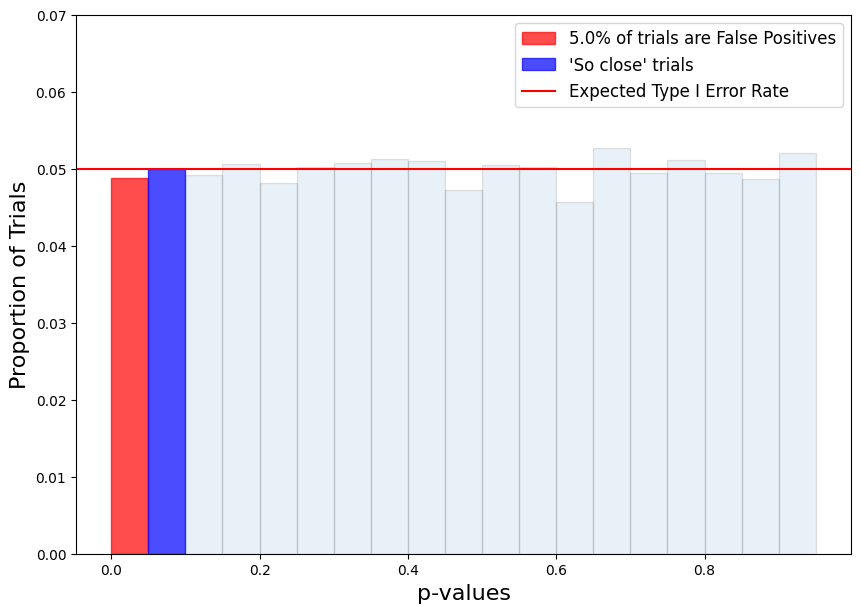

In [34]:
# Plot the pvalues histogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

bins = np.arange(0, 1, 0.05)
factor = 1/len(pvals)
cnts, bins = np.histogram(pvals, bins=bins)
cnt, bin_left, patches = ax.hist(bins[:-1],
                                 bins,
                                 weights = factor*cnts,
                                 edgecolor = "black",
                                 alpha = 0.1)

patches[0].set_color("red")
patches[0].set_alpha(0.7)
patches[0].set_label("5.0% of trials are False Positives")

patches[1].set_color("blue")
patches[1].set_alpha(0.7)
patches[1].set_label("'So close' trials")

ax.axhline(0.05,
           color = "red",
           label = "Expected Type I Error Rate")

ax.set_ylim(0.0, 0.07)
ax.set_xlabel("p-values", fontsize=16)
ax.set_ylabel("Proportion of Trials", fontsize=16)

plt.legend(fontsize = 12)
plt.show()

- Figure above highlights in blue the trials where the p-values are **so-close** to exhibiting a significant effect, having magnitudes just above the $\alpha=0.05$ cut off

- If you were an experimenter & happen to get the **so-close** results, you might be tempted to just **extend** your experiment a little longer to see if the **p-values** for those "so-close" trials **decrease** enough to reach statistical significance.

- **Adding new samples** in this way seems totally reasonable because adding more sample will minimize the sample variance thus reduce the false positive rates.

- **But this is $n$ chasing, a common form of p-hacking, don't do it**

In [35]:
# Identify the so-close trials & its p-values
so_close_index = (pvals >= 0.05) & (pvals < 0.1)
so_close_trial_1 = np.array(dataset_trial[0])[so_close_index]
so_close_trial_2 = np.array(dataset_trial[1])[so_close_index]

In [36]:
# additional samples
n_additional = 1

# length of so close trial
n_so_close = len(so_close_trial_1)

# Generate additional samples
additional_samples = np.random.choice(data,
                                      size = (2, n_so_close),
                                      replace = False)

# add to the so close trial
hacked_data_1 = np.column_stack((so_close_trial_1, additional_samples[0]))
hacked_data_2 = np.column_stack((so_close_trial_2, additional_samples[1]))

In [37]:
# Find p_values of each sampled data
pvals_hacked = np.zeros(n_so_close)

for i in range(n_so_close):
    # Calculate pvalue
    pval_i = stats.ttest_ind(hacked_data_1[i],
                             hacked_data_2[i]).pvalue

    # Save p-value to pvals
    pvals_hacked[i] = pval_i


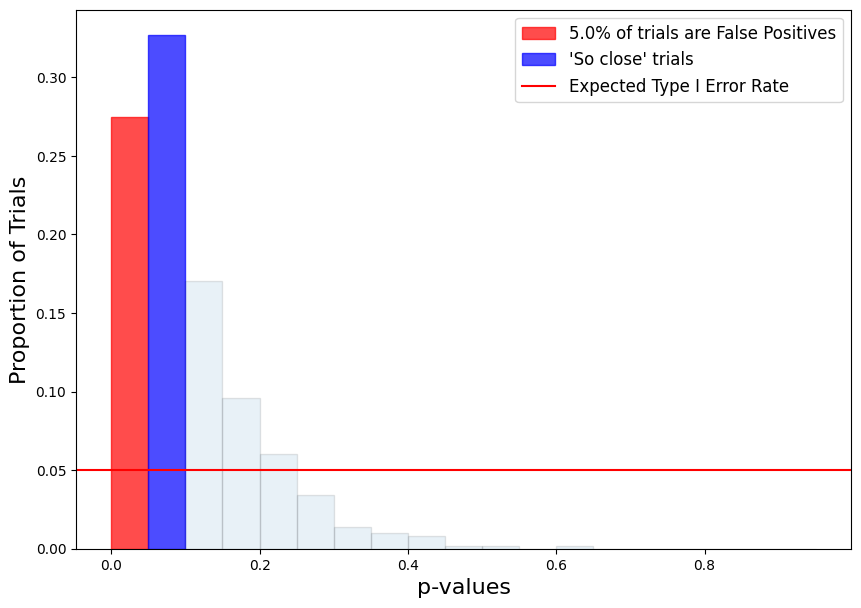

In [38]:
# Plot the pvalues histogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

bins = np.arange(0, 1, 0.05)
factor = 1/len(pvals_hacked)
cnts, bins = np.histogram(pvals_hacked, bins=bins)
cnt, bin_left, patches = ax.hist(bins[:-1],
                                 bins,
                                 weights = factor*cnts,
                                 edgecolor = "black",
                                 alpha = 0.1)

patches[0].set_color("red")
patches[0].set_alpha(0.7)
patches[0].set_label("5.0% of trials are False Positives")

patches[1].set_color("blue")
patches[1].set_alpha(0.7)
patches[1].set_label("'So close' trials")

ax.axhline(0.05,
           color = "red",
           label = "Expected Type I Error Rate")

ax.set_xlabel("p-values", fontsize=16)
ax.set_ylabel("Proportion of Trials", fontsize=16)

plt.legend(fontsize = 12)
plt.show()


- From the above **hacked dataset**, we see that the false positive rate is around 25% (red bar), **five times higher** than the previous **just from adding a single data point to those trials**

### **Simple other $n$ chasing simulation**
---

- What if we **increase** the number of hacked samples ($n_{\text{hacked}}$) and perform repeated experiments.
- Would we also get higher false positive rate?

<font color="red">Let's try it!</font>

In [39]:
def performHackedSimulation(n_additional, data_1, data_2):
    # length of so close trial
    n_so_close = len(so_close_trial_1)

    # Generate additional samples
    additional_samples = np.random.choice(data,
                                          size = (2, n_so_close),
                                          replace = False)

    # add to the so close trial
    hacked_data_1 = np.column_stack((so_close_trial_1, additional_samples[0]))
    hacked_data_2 = np.column_stack((so_close_trial_2, additional_samples[1]))

    # Find p_values of each sampled data
    pvals_hacked = np.zeros(n_so_close)

    for i in range(n_so_close):
        # Calculate pvalue
        pval_i = stats.ttest_ind(hacked_data_1[i],
                                hacked_data_2[i]).pvalue

        # Save p-value to pvals
        pvals_hacked[i] = pval_i

    # Plot the pvalues histogram
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

    bins = np.arange(0, 1, 0.05)
    factor = 1/len(pvals_hacked)
    cnts, bins = np.histogram(pvals_hacked, bins=bins)
    cnt, bin_left, patches = ax.hist(bins[:-1],
                                    bins,
                                    weights = factor*cnts,
                                    edgecolor = "black",
                                    alpha = 0.1)

    patches[0].set_color("red")
    patches[0].set_alpha(0.7)
    patches[0].set_label("5.0% of trials are False Positives")

    patches[1].set_color("blue")
    patches[1].set_alpha(0.7)
    patches[1].set_label("'So close' trials")

    ax.axhline(0.05,
            color = "red",
            label = "Expected Type I Error Rate")

    ax.set_xlabel("p-values", fontsize=16)
    ax.set_ylabel("Proportion of Trials", fontsize=16)

    plt.legend(fontsize = 12)
    plt.show()


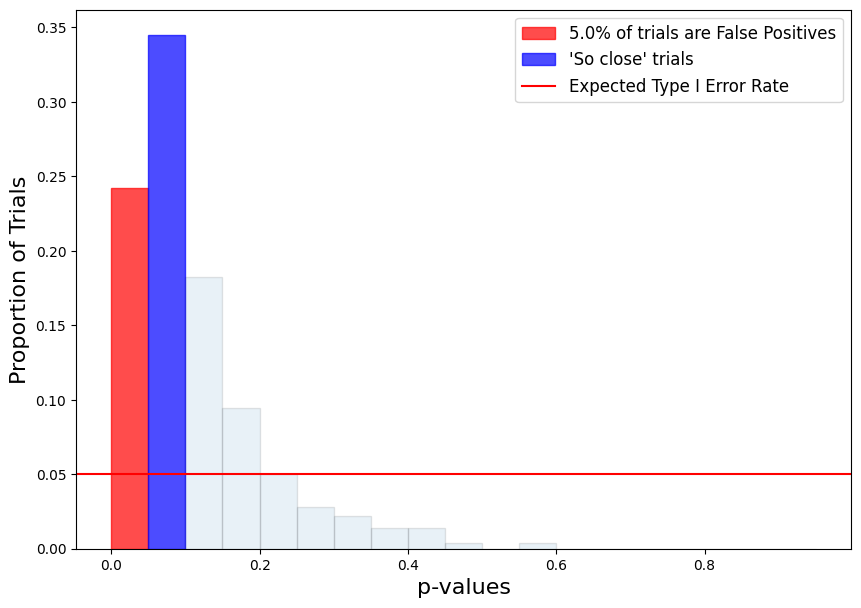

In [40]:
performHackedSimulation(n_additional = 50,
                        data_1 = so_close_trial_1,
                        data_2 = so_close_trial_2)

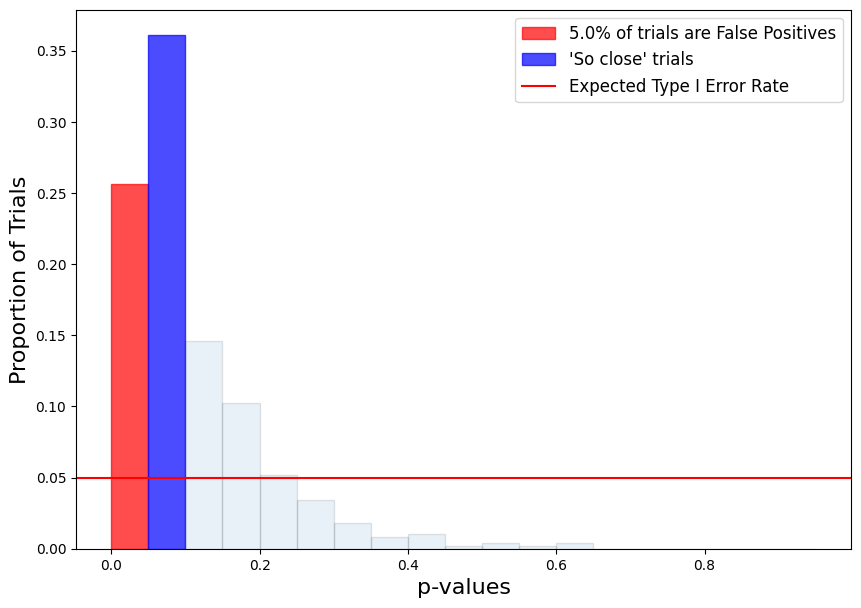

In [41]:
performHackedSimulation(n_additional = 1000,
                        data_1 = so_close_trial_1,
                        data_2 = so_close_trial_2)

- The results are similar, you will get higher false positive rates.

**Remember**
- Suppose you've designed an experiment, say with $n = 50$
- After getting $n=50$, your experiment did not reach significance.
- Then decide to keep running the experiment after looking at the final results.
- If you've ever said something like **oh, let's just run it a little longer**, then you're probably p-hacking.

# <font color='blue'>Woman Labor
---
- The task inferring causality is determine whether the association or relationship in data is causal.
- Understanding how variables are related helps determine causal effects. However, we can’t infer causality from a relationship alone.
- We will practicing describing relationship using conditional mean and regression through Woman Labor Case
- We want to describe how Women Wage Rate are relate to other family situation

### Load Data

- Here's the dataset of US women’s labor force participation and earnings from 1975.
- It contain the observations from the Panel Study of Income Dynamics (PSID), are married women.

In [42]:
womanlabor = pd.read_csv("Mroz.csv")
womanlabor

,lfp,k5,k618,age,wc,hc,lwg,inc
0,yes,1,0,32,no,no,1.210165,10.910001
1,yes,0,2,30,no,no,0.328504,19.500000
2,yes,1,3,35,no,no,1.514128,12.039999
3,yes,0,3,34,no,no,0.092115,6.800000
4,yes,1,2,31,yes,no,1.524280,20.100000
...,...,...,...,...,...,...,...,...
747,no,0,2,40,yes,yes,1.082864,28.200001
748,no,2,3,31,no,no,1.158040,10.000000
749,no,0,0,43,no,no,0.888140,9.952000
750,no,0,0,60,no,no,1.224974,24.983999


### Variables Name Definition

- `lfp`: Labor-force participation
- `k5`: Number of children 5 years old or younger
- `k618`: Number of children 6 to 17 years old
- `age`: Age in years
- `wc`: Wife attended college
- `hc`: Husband attended college
- `lwg`: Log expected wage rate. For women in the labor force, the actual wage rate; for women not in the labor force, an imputed value based on the regression of lwg on the other variables.
- `inc`: Family income exclusive of wife's income

Since we want to know the relationship from women wage, we need the data of working women only

In [43]:
# Keep just working women
womanlabor = womanlabor[womanlabor['lfp'] == "yes"]

In [44]:
# Create unlogged earnings
womanlabor.loc[:,'w_earn'] = womanlabor['lwg'].apply('exp')

/tmp/ipython-input-44-1828106370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  womanlabor.loc[:,'w_earn'] = womanlabor['lwg'].apply('exp')


### Women's Earning and Other Earnings

Scatterplot between women’s earnings and other earnings in the household among women who work

Text(0.5, 1.0, 'Women’s earnings and other earnings in the household')

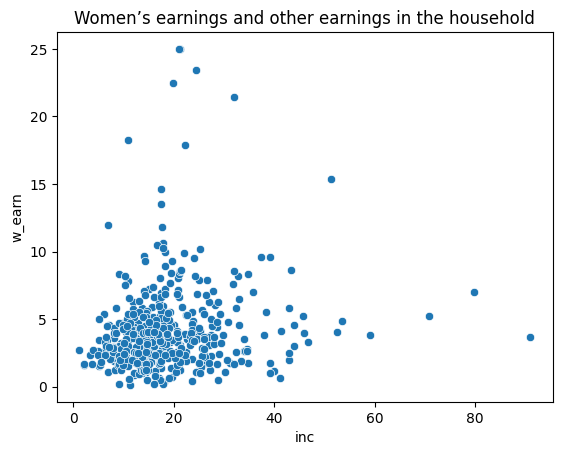

In [45]:
sns.scatterplot(x = 'inc', y = 'w_earn', data = womanlabor)
plt.title("Women’s earnings and other earnings in the household")

[None, None]

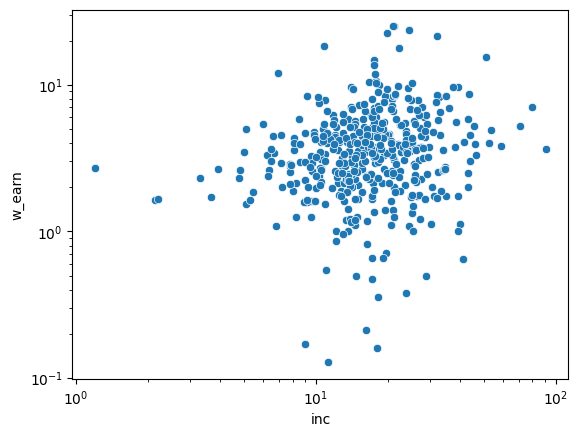

In [46]:
sns.scatterplot(x = 'inc', y = 'w_earn', data = womanlabor).set(xscale="log", yscale="log")

### Women Earning and Women College

- Now let's describe the relationship between women earning and women college using **conditional distribution**

Text(0.5, 0, 'Women College')

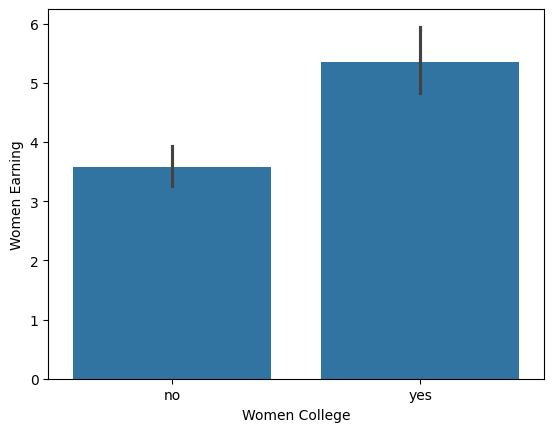

In [47]:
sns.barplot(x = womanlabor["wc"],
            y = womanlabor["w_earn"])

plt.ylabel("Women Earning")
plt.xlabel("Women College")

In [48]:
mean_wlabor_by_college = womanlabor.groupby('wc')[['w_earn']].mean()
mean_wlabor_by_college

,w_earn
wc,
no,3.583539
yes,5.343309


In [49]:
diff_wlabor = mean_wlabor_by_college.loc["yes"] - mean_wlabor_by_college.loc["no"]
diff_wlabor

,0
w_earn,1.759769


### Linear Regression with Single Predictor

Linear regression curves of the mean of log women’s earnings conditional on the log amount of other earnings in the household

In [50]:
womanlabor.loc[:,'linc'] = np.log(womanlabor['inc'])

/tmp/ipython-input-50-3741833916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  womanlabor.loc[:,'linc'] = np.log(womanlabor['inc'])


In [51]:
# Create OLS model object
model1 = sm.ols('lwg ~ linc', womanlabor)

# Fit the model
results1 = model1.fit()

# Print the results
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                    lwg   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     11.65
Date:                Fri, 18 Jul 2025   Prob (F-statistic):           0.000703
Time:                        22:19:11   Log-Likelihood:                -461.34
No. Observations:                 427   AIC:                             926.7
Df Residuals:                     425   BIC:                             934.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5690      0.185      3.079      0.0

### Linear Regression with Multiiple Predictor

- Run a linear regression of log women’s earnings on log other earnings in the household, by itself and including controls for college attendance and the number of children under five in the household
- If we add, Woman College and Kids under 5, we get:

In [52]:
# Create OLS model object
model2 = sm.ols('lwg ~ linc + wc + k5', womanlabor)

# Fit the model
results2 = model2.fit()

# Print the results
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                    lwg   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     10.67
Date:                Fri, 18 Jul 2025   Prob (F-statistic):           8.92e-07
Time:                        22:19:13   Log-Likelihood:                -451.54
No. Observations:                 427   AIC:                             911.1
Df Residuals:                     423   BIC:                             927.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7065      0.184      3.833      0.0

- It telling us that some of the relationship we saw between income and wage rate was explained by woman college and/or kids under five.
- The coefficient of Income has changed a bit, from .22 to .14,
- It shows we still have the remaining relationship between WageRate and Income after accounting for College and Kids Under Five.

### Reference

- The Effect Chapter 4 by Nick Huntington-Klein.
- Mroz, T. A. (1987) The sensitivity of an empirical model of married women's hours of work to economic and statistical assumptions. *Econometrica* 55, 765-799.
- Simpson's Paradox from STAT/CS/IS 107 Data Science Discovery, The University of Illinois.
- https://scikit-learn.org/stable/auto_examples/inspection/plot_causal_interpretation.html